# Forecasting American Energy Consumption on hourly basis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

def mean_absolute_percenatge_error(y_true, y_predict):
    """Calculate mean absolute percenatage error (MAPE) given y_true, y_predict"""
    y_true, y_predict = np.array(y_true), np.array(y_predict)
    return np.mean(np.abs((y_true - y_predict) / y_true)) * 100

In [2]:
url_E = '/kaggle/input/hourly-energy-consumption/PJME_hourly.csv'
df_E = pd.read_csv(url_E)
df_E
url_W = '/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv'
df_W = pd.read_csv(url_W)

In [3]:
df_E = df_E.set_index('Datetime')
df_W = df_W.set_index('Datetime')
df_E.index = pd.to_datetime(df_E.index)
df_W.index = pd.to_datetime(df_W.index)

In [4]:
df = df_E.merge(df_W, how='inner', left_index=True, right_index= True)
df.head()

,PJME_MW,PJMW_MW
Datetime,,
2002-04-01 01:00:00,21734.0,4374.0
2002-04-01 02:00:00,20971.0,4306.0
2002-04-01 03:00:00,20721.0,4322.0
2002-04-01 04:00:00,20771.0,4359.0
2002-04-01 05:00:00,21334.0,4436.0


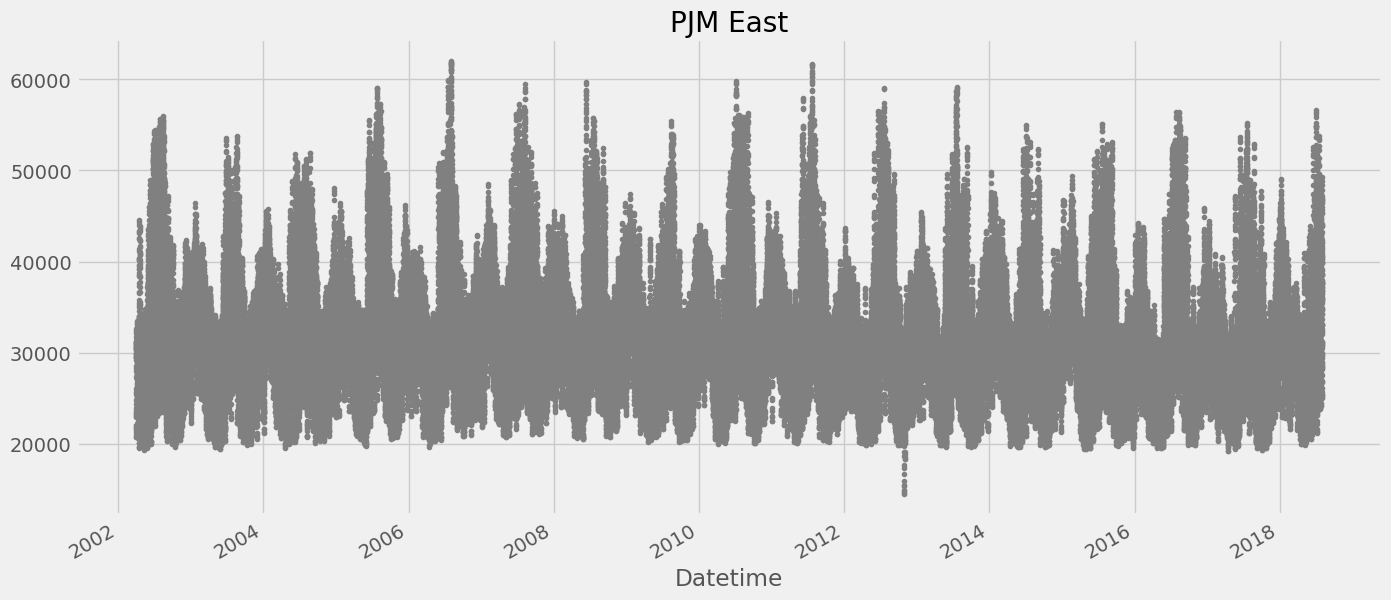

In [5]:
df['PJME_MW'].plot(style='.', figsize=(15,7), legend=False, color='grey', title='PJM East')
plt.show()

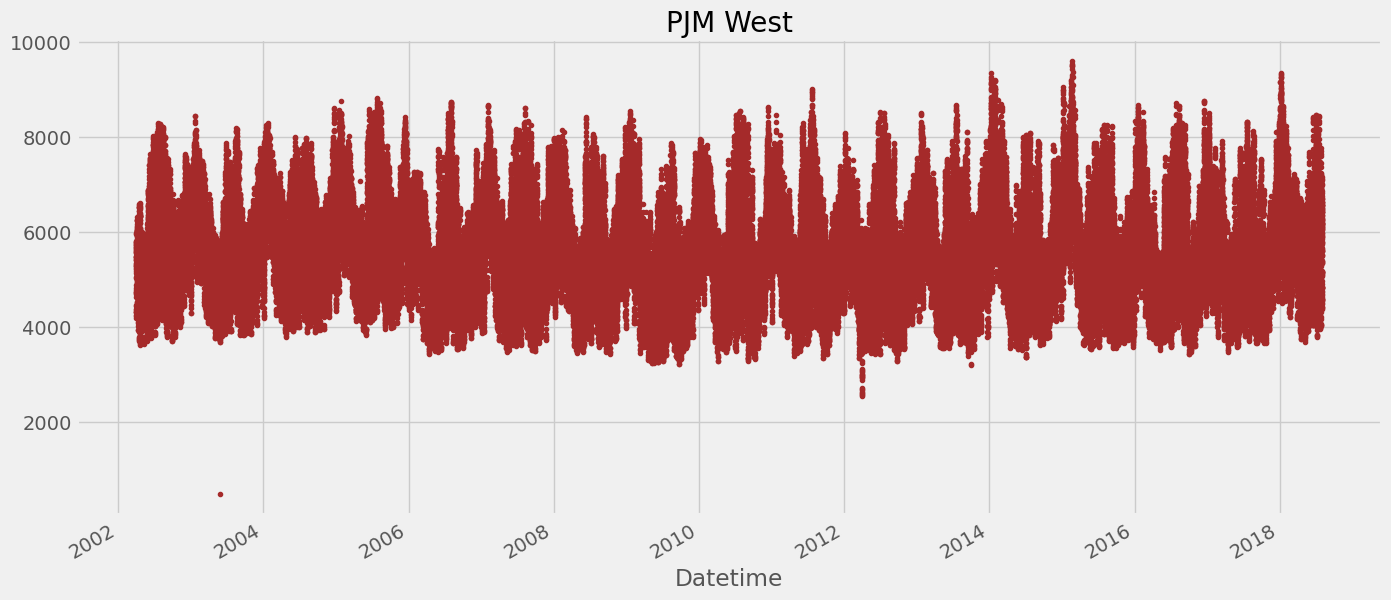

In [6]:
df['PJMW_MW'].plot(style='.', figsize=(15,7), legend=False, color='brown', title='PJM West')
plt.show()

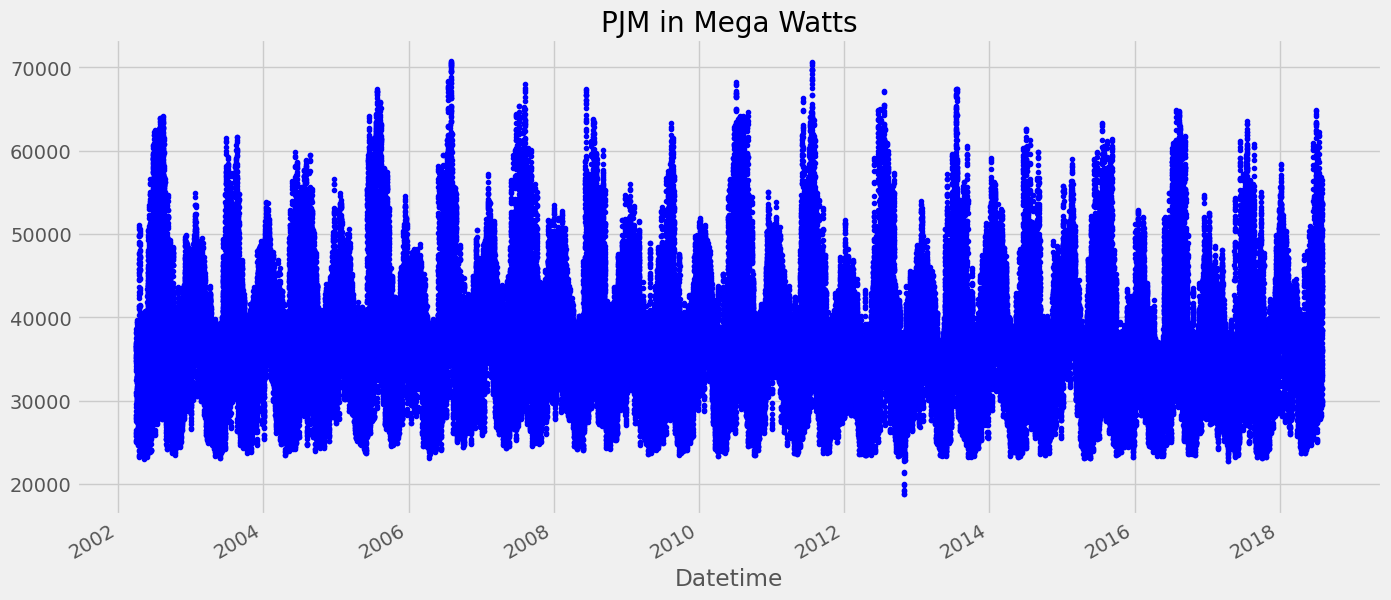

In [7]:
df['PJM_MW'] = df['PJME_MW'] + df['PJMW_MW']
df['PJM_MW'].plot(style='.', title='PJM in Mega Watts', color='blue', figsize=(15,7))
plt.show()

## Create time series features to interact with the PJM data.

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)


def create_features(df, label = None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df['date'].dt.month*100 + df['date'].dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], bins=[0, 300, 602, 900, 1300],
                         labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    X = df[['hour', 'weekday', 'month',
            'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear',
            'season']]
    if label:
        y=df[label]
        return X, y
    return X
X, y = create_features(df, label='PJM_MW')
features_and_target = pd.concat([X, y], axis=1)
    

In [9]:
features_and_target.head()

,hour,weekday,month,year,quarter,dayofyear,dayofmonth,weekofyear,season,PJM_MW
Datetime,,,,,,,,,,
2002-04-01 01:00:00,1,Monday,4,2002,2,91,1,14,Spring,26108.0
2002-04-01 02:00:00,2,Monday,4,2002,2,91,1,14,Spring,25277.0
2002-04-01 03:00:00,3,Monday,4,2002,2,91,1,14,Spring,25043.0
2002-04-01 04:00:00,4,Monday,4,2002,2,91,1,14,Spring,25130.0
2002-04-01 05:00:00,5,Monday,4,2002,2,91,1,14,Spring,25770.0


## Plotting the trend of certain features

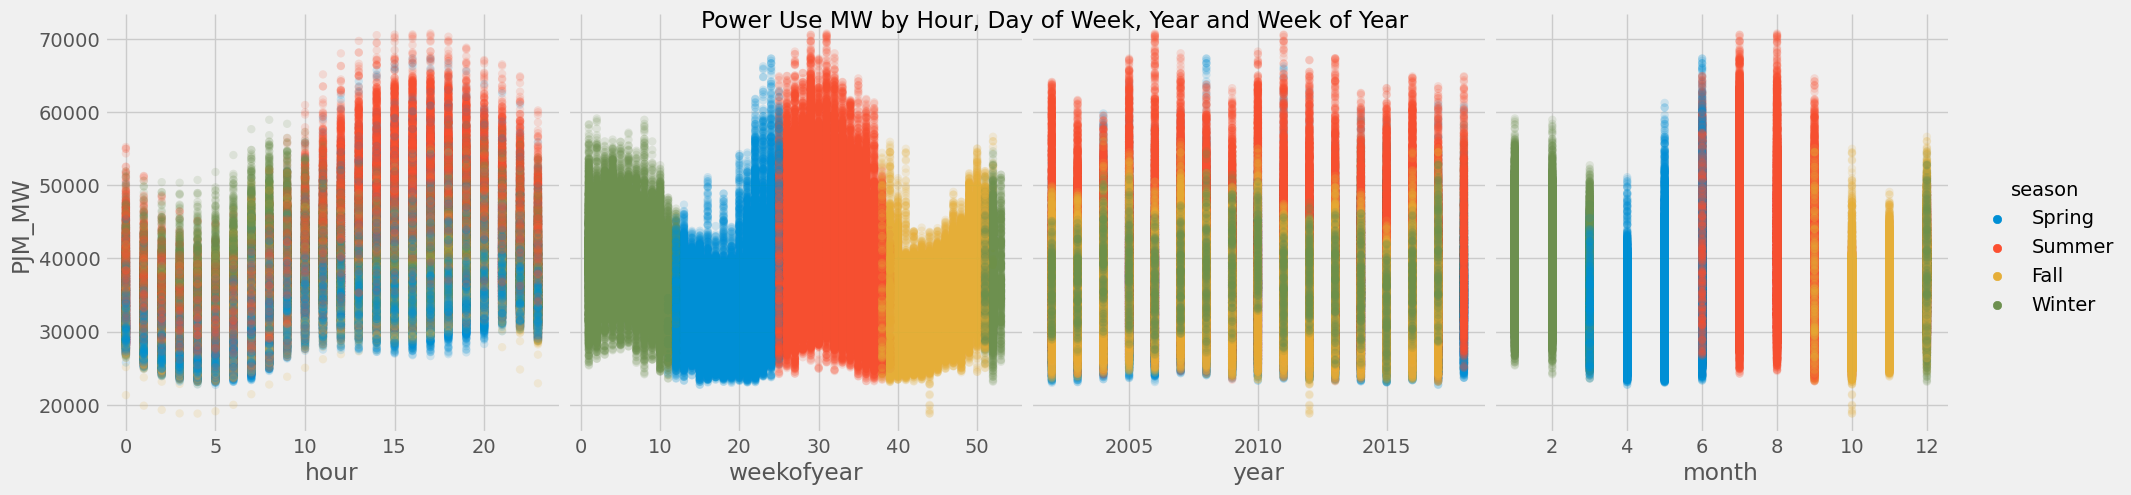

In [10]:
sns.pairplot(data=features_and_target.dropna(), x_vars=['hour', 'weekofyear', 'year', 'month']
             , y_vars=['PJM_MW'], hue='season',
             height=5, plot_kws={'alpha':0.15, 'linewidth':0})

plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

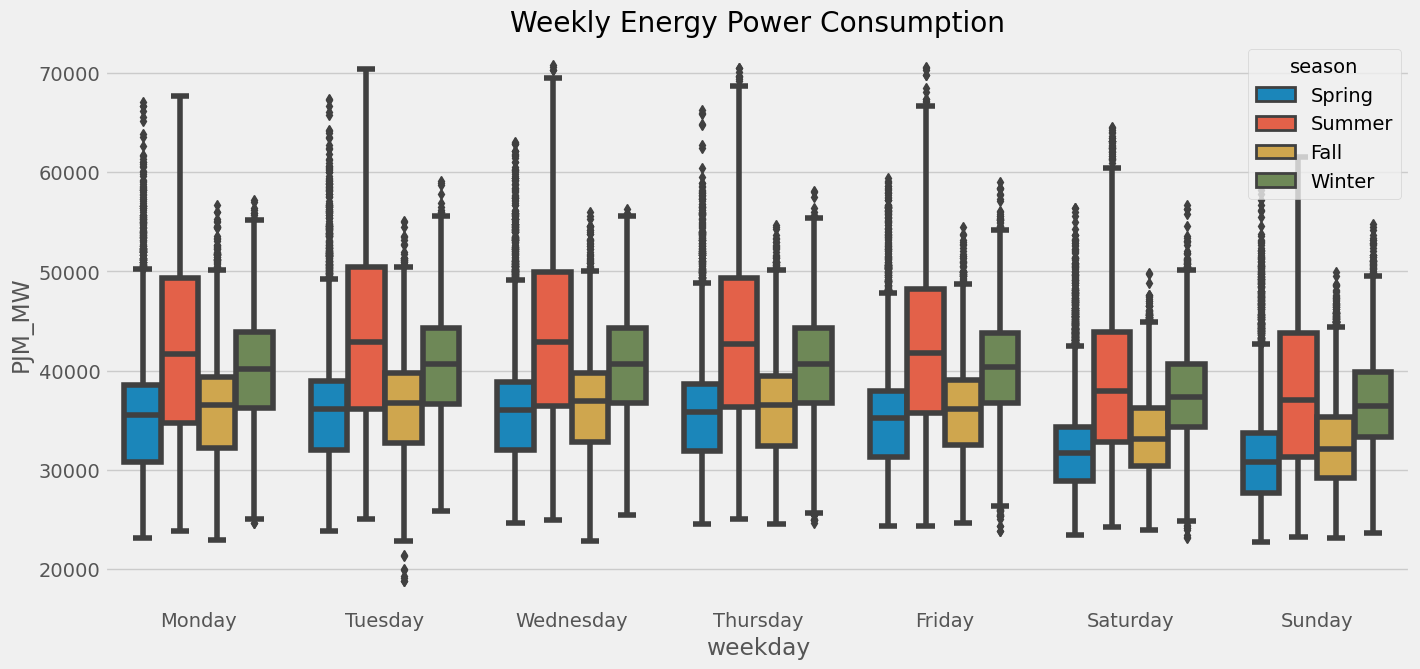

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(data=features_and_target.dropna(), x='weekday', y='PJM_MW', hue='season', ax =ax)
ax.set_title('Weekly Energy Power Consumption')
plt.show()

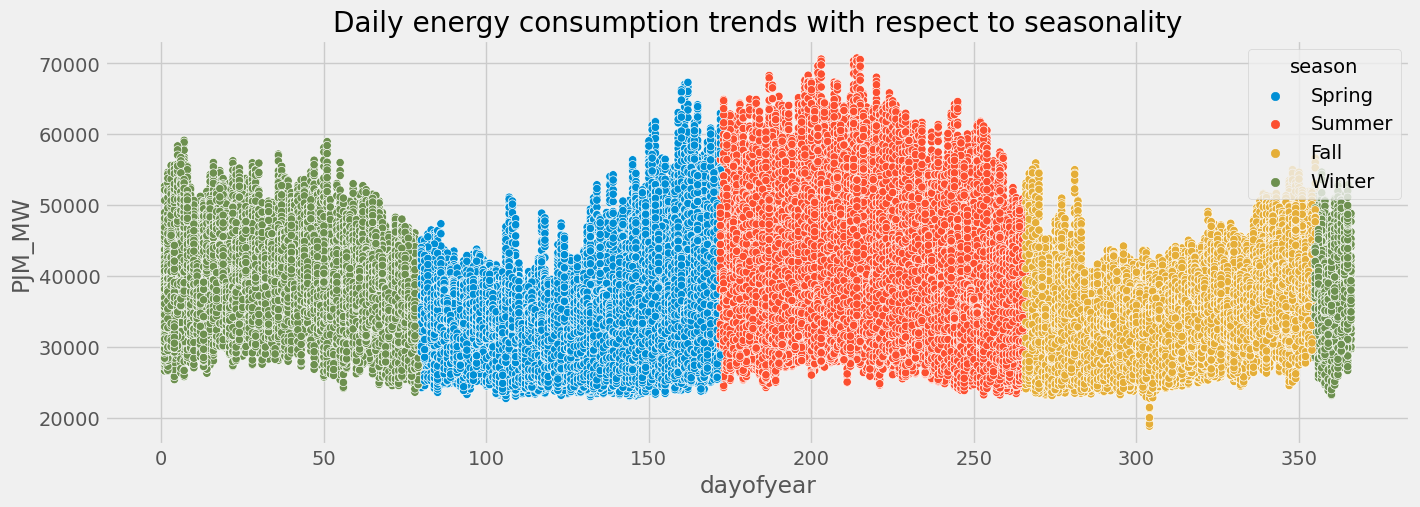

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=features_and_target, x='dayofyear', y='PJM_MW', hue='season', ax=ax)
ax.set_title('Daily energy consumption trends with respect to seasonality')
plt.show()

## Forcasting Model using Test/Train data.

- Splitting 'feature_and_target' data into testing and training data.
- Testing data comprises from 2002 to 2014
- Training data split from 2015 to 2018

In [13]:
features_and_target['year'].value_counts().sort_index()

2002    6597
2003    8758
2004    8782
2005    8758
2006    8758
2007    8758
2008    8782
2009    8758
2010    8757
2011    8758
2012    8782
2013    8758
2014    8762
2015    8762
2016    8786
2017    8762
2018    5136
Name: year, dtype: int64

In [14]:
features_and_target.head()

,hour,weekday,month,year,quarter,dayofyear,dayofmonth,weekofyear,season,PJM_MW
Datetime,,,,,,,,,,
2002-04-01 01:00:00,1,Monday,4,2002,2,91,1,14,Spring,26108.0
2002-04-01 02:00:00,2,Monday,4,2002,2,91,1,14,Spring,25277.0
2002-04-01 03:00:00,3,Monday,4,2002,2,91,1,14,Spring,25043.0
2002-04-01 04:00:00,4,Monday,4,2002,2,91,1,14,Spring,25130.0
2002-04-01 05:00:00,5,Monday,4,2002,2,91,1,14,Spring,25770.0


In [15]:
split = '01-01-2015'
training = df.loc[df.index <= split].copy()
testing = df.loc[df.index >= split].copy()

In [16]:
training.shape

(111769, 3)

In [17]:
testing.shape

(31446, 3)

### Plotting training and testing datasets

<AxesSubplot:xlabel='Datetime'>

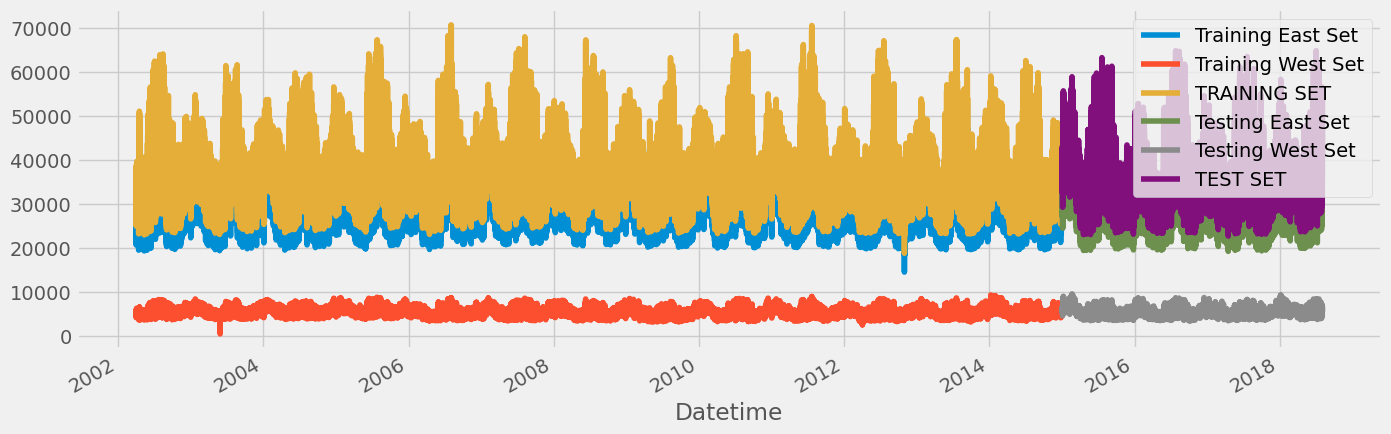

In [18]:
training.rename(columns={'PJM_MW':'TRAINING SET', 'PJME_MW': 'Training East Set', 'PJMW_MW':'Training West Set'}) \
.join(testing.rename(columns={'PJM_MW':'TEST SET', 'PJME_MW': 'Testing East Set', 'PJMW_MW':'Testing West Set'}), how='outer') \
.plot(figsize=(15,5))

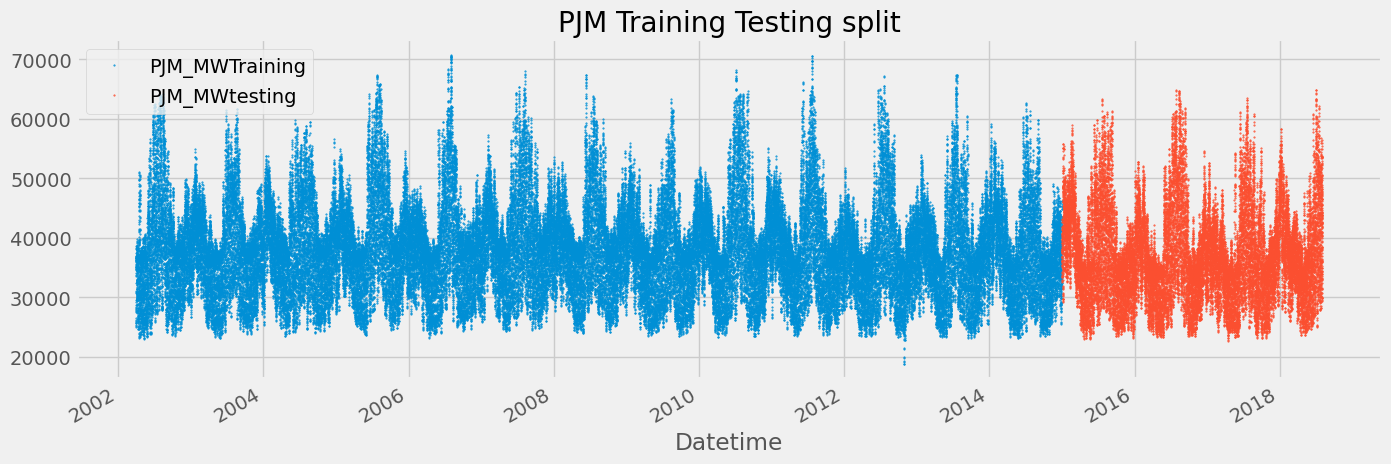

In [19]:
pd.DataFrame(training['PJM_MW']).join(pd.DataFrame(testing['PJM_MW']),how='outer', lsuffix='Training', rsuffix='testing') \
.plot(figsize=(15,5),title='PJM Training Testing split', ms=1, style='.')
plt.show()

## Prophet Model

 - The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [20]:
# Firstly format the data for Prophet model as  ds and y.

pjm_training = pd.DataFrame(training['PJM_MW']).reset_index().rename(columns={'Datetime':'ds', 'PJM_MW':'y'})
pjm_testing = pd.DataFrame(testing['PJM_MW']).reset_index().rename(columns={'Datetime':'ds', 'PJM_MW':'y'})

In [21]:
# Setup and train model and fit
m=Prophet()
m.fit(pjm_training)

16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:59:11 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
112126,2015-12-28
112127,2015-12-29
112128,2015-12-30
112129,2015-12-31
112130,2016-01-01


In [23]:
# Predict on testing set with model

forecast = m.predict(pjm_testing)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
31441,2018-08-02 20:00:00,48149.198830,15289.513814,82355.012066
31442,2018-08-02 21:00:00,47290.512526,14263.796370,80841.315109
31443,2018-08-02 22:00:00,45436.115864,13431.771885,79154.990207
31444,2018-08-02 23:00:00,42899.131336,10938.981032,77061.315494
31445,2018-08-03 00:00:00,40214.457192,8437.472401,73183.135666


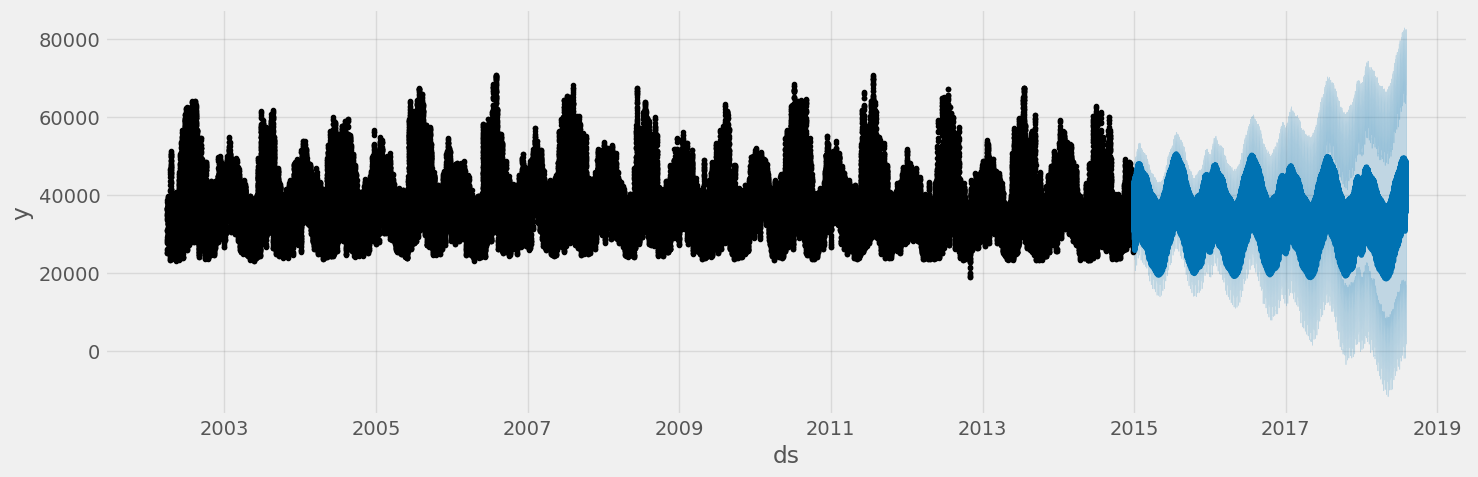

In [24]:
fig1, ax = plt.subplots(figsize=(15,5))
fig1 = m.plot(forecast, ax)